<a href="https://colab.research.google.com/github/VicenteSorianoAguilar/MPA-MLF/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MPA-MLF-Final **project**

**Please import the training and testing files in separated folders named 'test' and 'train'. Also, import 'label_train.csv' and 'test_format.csv' in a separated folder named 'csv'**

Initial Configuration

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from scipy import signal
from scipy.fft import fft
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
!pip install PyWavelets
import pywt
from imblearn.under_sampling import RandomUnderSampler
import time
from sklearn.utils.class_weight import compute_class_weight


# Define the local paths
train_folder='/content/train'
test_folder='/content/test'
label_train_path = '/content/csv/labeltrain.csv'
test_format_path='/content/csv/testformat.csv'

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.3 MB/s eta 0:00:00


Data Loading

In [ ]:
# Start timing
start_time = time.time()

# Load the training labels
train_labels = pd.read_csv(label_train_path)

# Load the training data (filtering only .npy files)
train_files = sorted([f for f in os.listdir(train_folder) if f.endswith('.npy')])
X_train = np.array([np.load(os.path.join(train_folder, file)) for file in train_files])

# Load the test data (filtering only .npy files)
test_files = sorted([f for f in os.listdir(test_folder) if f.endswith('.npy')])
X_test = np.array([np.load(os.path.join(test_folder, file)) for file in test_files])

# Display shapes of the datasets
print("Training samples shape:", X_train.shape)
print("Training labels shape:", train_labels.shape)
print("Test samples shape:", X_test.shape)

# Extract the labels (assuming they are in the second column of train_labels)
y_train = train_labels.iloc[:, 1].values

# Data loading time
print(f"Data loading time: {time.time() - start_time:.2f} seconds")

Training samples shape: (1491, 72, 48)
Training labels shape: (1491, 2)
Test samples shape: (120, 72, 48)
Data loading time: 0.66 seconds


Visualitation and initial analysis

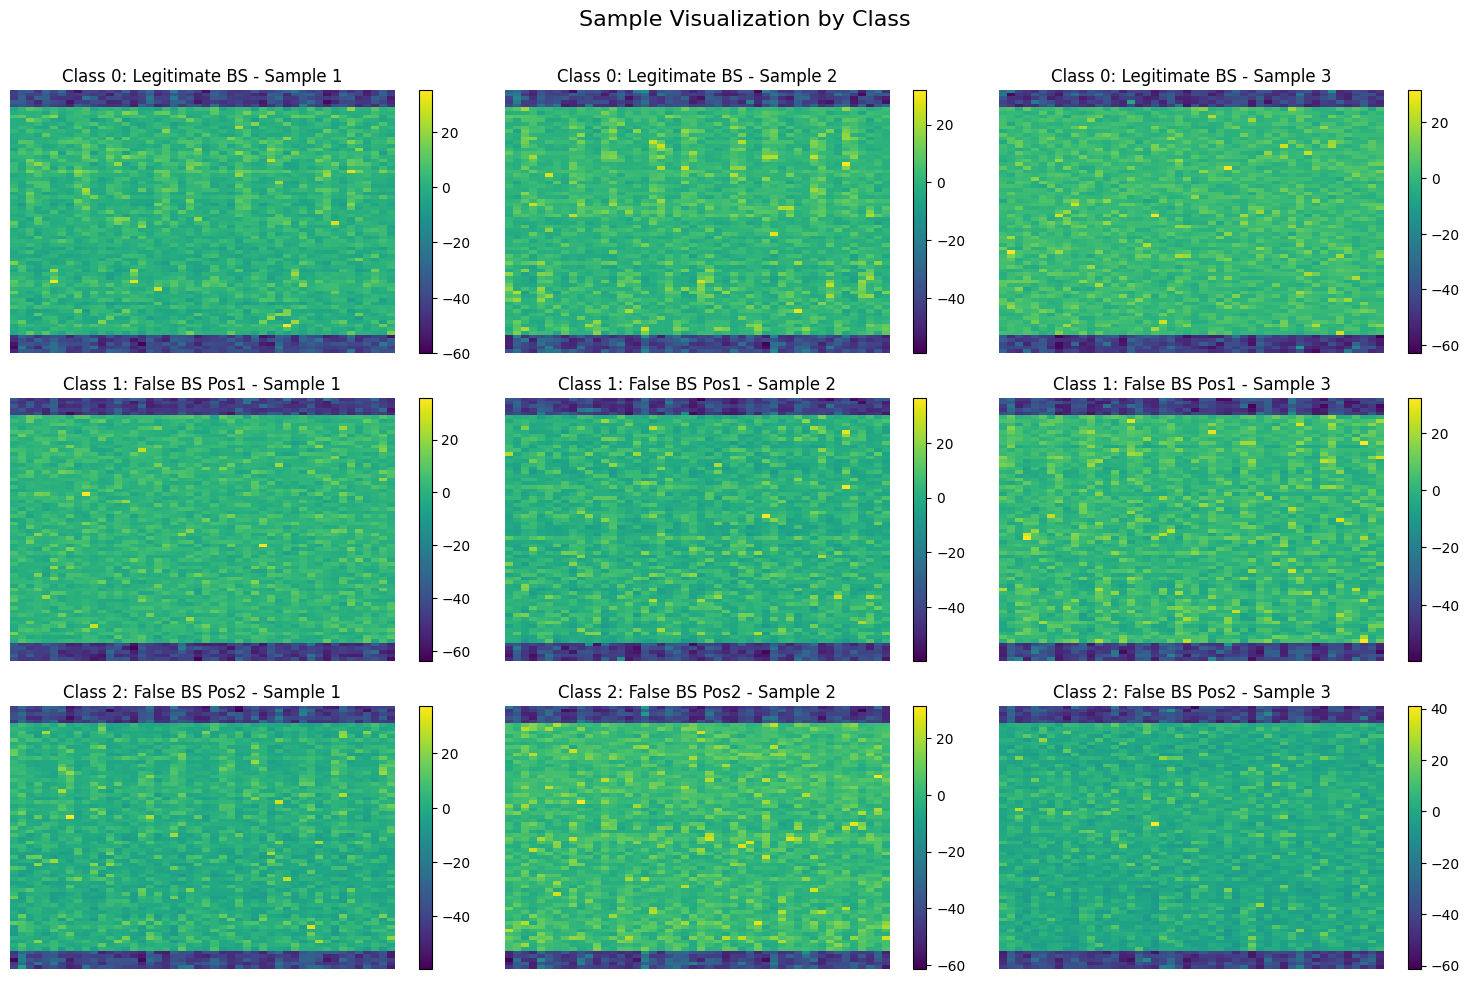

Class Distribution in Training Set:
0    1209
1     141
2     141
Name: count, dtype: int64


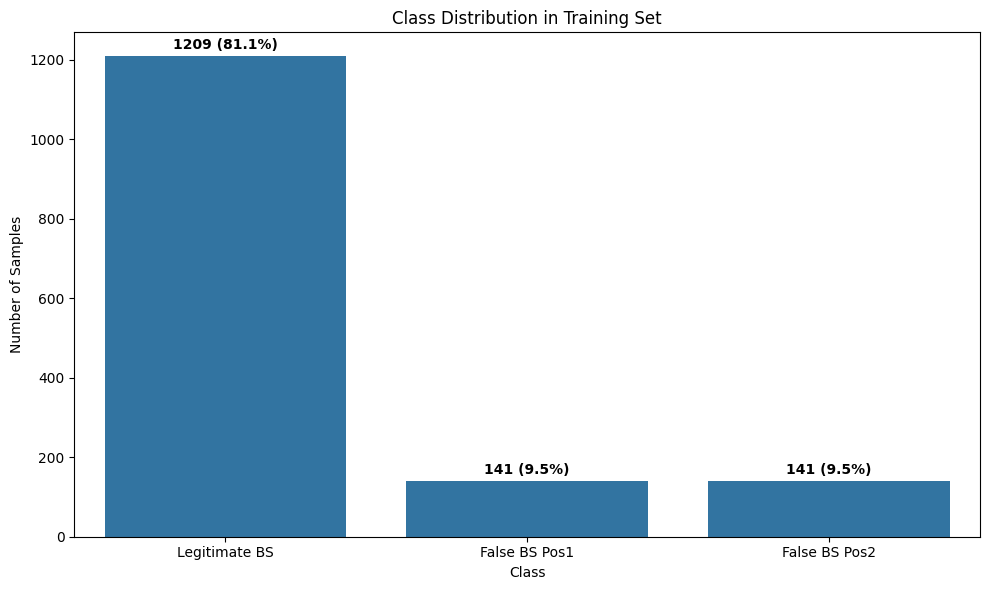

In [ ]:
# Visualize some training samples
plt.figure(figsize=(15, 10))
plt.suptitle("Sample Visualization by Class", fontsize=16)

# Show samples of each class
classes = [0, 1, 2]
class_names = ['Legitimate BS', 'False BS Pos1', 'False BS Pos2']

for i, cls in enumerate(classes):
    indices = np.where(y_train == cls)[0]
    for j in range(min(3, len(indices))):
        plt.subplot(3, 3, i*3 + j + 1)
        plt.imshow(X_train[indices[j]], aspect='auto', cmap='viridis')
        plt.title(f'Class {cls}: {class_names[cls]} - Sample {j+1}')
        plt.colorbar()
        plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Class distribution analysis
print("Class Distribution in Training Set:")
train_class_counts = pd.Series(y_train).value_counts().sort_index()
print(train_class_counts)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=[class_names[i] for i in range(3)], y=train_class_counts.values)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
for i, count in enumerate(train_class_counts.values):
    plt.text(i, count + 10, f"{count} ({count/len(y_train)*100:.1f}%)",
             ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

Function for extracting telecommunication-specific features

In [ ]:
def extract_telecom_features(signal_data):
    """
    Extracts telecommunication-specific features from signal data.

    Args:
        signal_data: Array of shape (n_samples, 72, 48) or (72, 48) for a single sample

    Returns:
        features: Array of extracted features
    """
    # Check if it's a single sample or multiple
    single_sample = (len(signal_data.shape) == 2)
    if single_sample:
        signal_data = np.expand_dims(signal_data, axis=0)

    n_samples = signal_data.shape[0]
    features_list = []

    for i in range(n_samples):
        sample = signal_data[i]
        feature_vector = []

        # 1. Time domain features
        # - Basic statistics by row (subcarriers)
        row_means = np.mean(sample, axis=1)
        row_stds = np.std(sample, axis=1)
        row_max = np.max(sample, axis=1)
        row_min = np.min(sample, axis=1)

        # - Aggregated statistics
        feature_vector.extend([
            np.mean(row_means), np.std(row_means),
            np.mean(row_stds), np.std(row_stds),
            np.mean(row_max), np.std(row_max),
            np.mean(row_min), np.std(row_min)
        ])

        # 2. Frequency domain features
        # - FFT by row and extract relevant features
        row_ffts = np.abs(fft(sample, axis=1))
        fft_means = np.mean(row_ffts, axis=1)
        fft_stds = np.std(row_ffts, axis=1)
        fft_max = np.max(row_ffts, axis=1)

        feature_vector.extend([
            np.mean(fft_means), np.std(fft_means),
            np.mean(fft_stds), np.std(fft_stds),
            np.mean(fft_max), np.std(fft_max)
        ])

        # 3. Power spectral density analysis
        # - Calculate PSD and extract features
        freqs, psd = signal.welch(np.mean(sample, axis=0), fs=1.0, nperseg=min(32, sample.shape[1]))
        feature_vector.extend([
            np.mean(psd), np.std(psd), np.max(psd),
            np.argmax(psd), np.median(psd)
        ])

        # 4. Wavelet transform-based features
        # - Apply discrete wavelet transform
        coeffs = pywt.wavedec2(sample, 'db1', level=2)
        # - Extract statistics from coefficients
        wavelet_features = []
        for coeff in coeffs:
            if isinstance(coeff, tuple):
                for c in coeff:
                    wavelet_features.extend([np.mean(c), np.std(c), np.max(c)])
            else:
                wavelet_features.extend([np.mean(coeff), np.std(coeff), np.max(coeff)])

        feature_vector.extend(wavelet_features[:15])  # Limit number of wavelet features

        # 5. Correlation features
        # Calculate autocorrelation for each row and average results
        row_autocorr_values = []
        for row in sample:
            # Calculate autocorrelation and get positive values
            corr = np.correlate(row, row, mode='full')
            # Take only the positive half
            mid = len(corr) // 2
            corr = corr[mid:]
            if len(corr) >= 5:  # Ensure there are enough values
                row_autocorr_values.append(corr[:5])

        if row_autocorr_values:
            row_autocorr_mean = np.mean(row_autocorr_values, axis=0)
            row_autocorr_mean_value = np.mean(row_autocorr_mean)
        else:
            row_autocorr_mean_value = 0

        # Similar for columns
        col_autocorr_values = []
        for col in sample.T:
            corr = np.correlate(col, col, mode='full')
            mid = len(corr) // 2
            corr = corr[mid:]
            if len(corr) >= 5:
                col_autocorr_values.append(corr[:5])

        if col_autocorr_values:
            col_autocorr_mean = np.mean(col_autocorr_values, axis=0)
            col_autocorr_mean_value = np.mean(col_autocorr_mean)
        else:
            col_autocorr_mean_value = 0

        feature_vector.extend([row_autocorr_mean_value, col_autocorr_mean_value])

        # 6. Entropy features
        # - Calculate Shannon entropy by row and column
        def entropy(x):
            x = np.abs(x)
            x_sum = np.sum(x)
            if x_sum == 0:
                return 0
            x = x / x_sum
            # Only consider positive values for logarithmic calculation
            x = x[x > 0]
            if len(x) == 0:
                return 0
            return -np.sum(x * np.log2(x))

        # Calculate entropy for each row and column
        row_entropies = [entropy(row) for row in sample]
        col_entropies = [entropy(col) for col in sample.T]

        feature_vector.extend([
            np.mean(row_entropies),
            np.mean(col_entropies)
        ])

        # 7. Approximate SNR (signal-to-noise ratio)
        signal_power = np.mean(np.square(sample))
        noise_estimate = np.std(sample)
        snr_estimate = signal_power / (noise_estimate + 1e-10)
        feature_vector.append(snr_estimate)

        # 8. Additional signal features
        # - Skewness and kurtosis
        row_skew = np.mean([np.mean((row - np.mean(row))**3) / (np.std(row)**3 + 1e-10) for row in sample])
        row_kurt = np.mean([np.mean((row - np.mean(row))**4) / (np.std(row)**4 + 1e-10) for row in sample])
        feature_vector.extend([row_skew, row_kurt])

        features_list.append(feature_vector)

    features = np.array(features_list)
    print(f"Extracted features: {features.shape[1]} features per sample")

    return features

Feature Extraction and Data Preparation

Extracting telecommunication-specific features...
Extracted features: 41 features per sample
Extracted features: 41 features per sample
Training features shape: (1491, 41)
Test features shape: (120, 41)
Applying aggressive undersampling to balance classes...
Class distribution after undersampling:
0    226
1    113
2    113
Name: count, dtype: int64
Aggressive class weights: {0: np.float64(0.6666666666666666), 1: np.float64(2.6666666666666665), 2: np.float64(2.6666666666666665)}


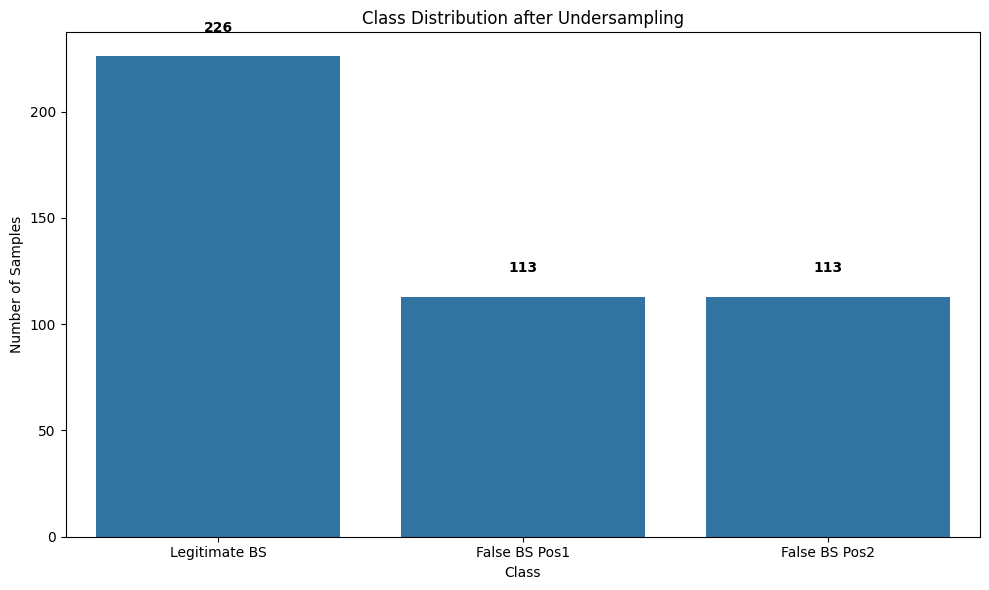

Feature extraction and preparation time: 64.60 seconds


In [ ]:
# Start timing
feature_start_time = time.time()

# Extract features for training and test sets
print("Extracting telecommunication-specific features...")
X_train_features = extract_telecom_features(X_train)
X_test_features = extract_telecom_features(X_test)

# Display information about extracted features
print(f"Training features shape: {X_train_features.shape}")
print(f"Test features shape: {X_test_features.shape}")

# Scale features to improve performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# Split into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Apply aggressive undersampling instead of SMOTE
print("Applying aggressive undersampling to balance classes...")
under_sampler = RandomUnderSampler(
    sampling_strategy={
        0: min(len(y_train_final[y_train_final == 1]) * 2,
              len(y_train_final[y_train_final == 0]))
    },
    random_state=42
)
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_final, y_train_final)

# Verify distribution after undersampling
print("Class distribution after undersampling:")
balanced_class_counts = pd.Series(y_train_balanced).value_counts().sort_index()
print(balanced_class_counts)

# Calculate aggressive class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)

# Make weights even more aggressive for minority classes
class_weight_factor = 2.0
class_weights[1] *= class_weight_factor  # Class 1 (False BS Pos1)
class_weights[2] *= class_weight_factor  # Class 2 (False BS Pos2)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Aggressive class weights:", class_weight_dict)

# Plot class distribution after undersampling
plt.figure(figsize=(10, 6))
sns.barplot(x=[class_names[i] for i in range(3)], y=balanced_class_counts.values)
plt.title("Class Distribution after Undersampling")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
for i, count in enumerate(balanced_class_counts.values):
    plt.text(i, count + 10, f"{count}", ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Feature extraction and preparation time: {time.time() - feature_start_time:.2f} seconds")

Selection of the Most Relevant Features

Selecting the most relevant features...
Selected features: 41 out of 41


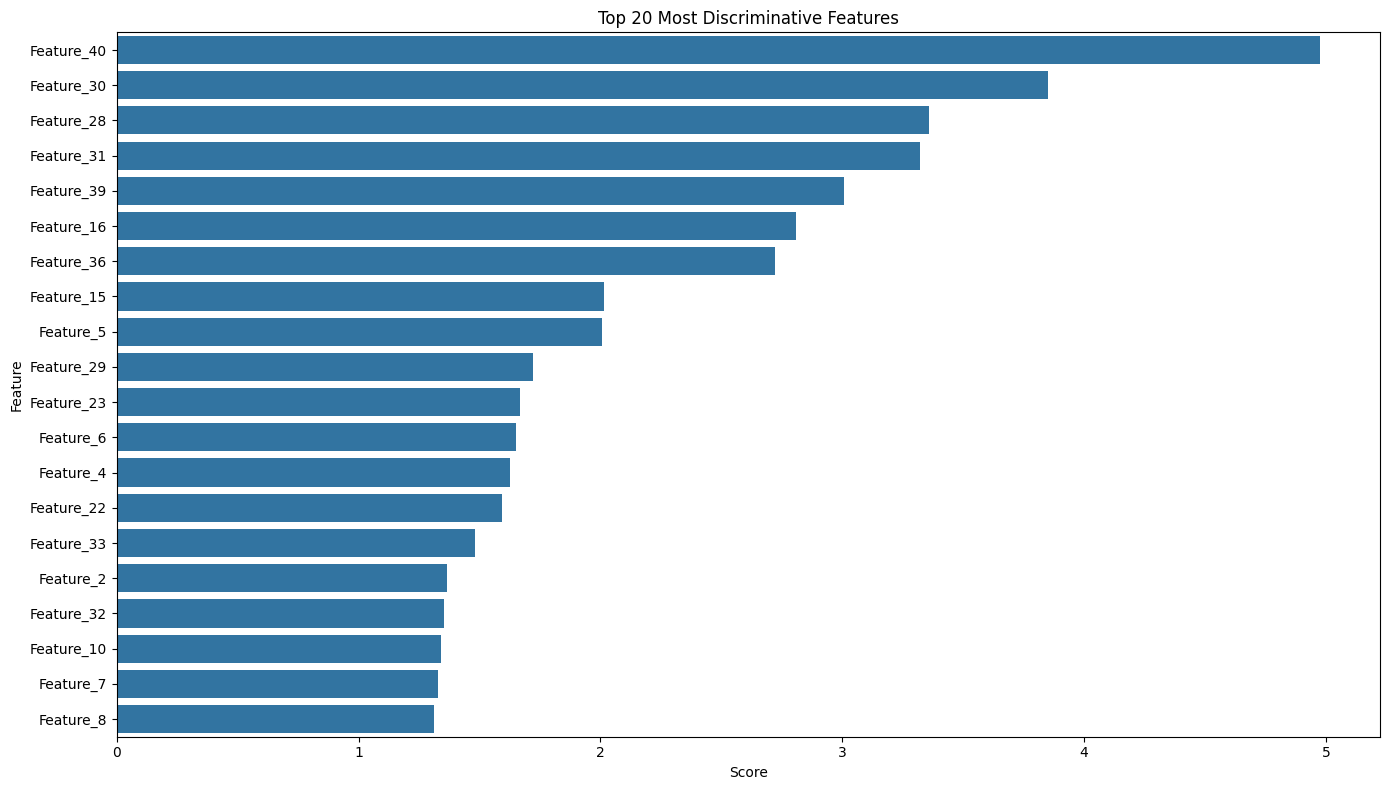

In [ ]:
# Select the most discriminative features
print("Selecting the most relevant features...")
selector = SelectKBest(f_classif, k=min(50, X_train_balanced.shape[1]))
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test_scaled)

print(f"Selected features: {X_train_selected.shape[1]} out of {X_train_balanced.shape[1]}")

# Visualize the most important features
feature_scores = pd.DataFrame({
    'Feature': [f'Feature_{i}' for i in range(X_train_balanced.shape[1])],
    'Score': selector.scores_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)

plt.figure(figsize=(14, 8))
top_features = feature_scores.head(20)
sns.barplot(x='Score', y='Feature', data=top_features)
plt.title('Top 20 Most Discriminative Features')
plt.tight_layout()
plt.show()

# Get indices of selected features for later reference
selected_features_indices = selector.get_support(indices=True)

Random Forest Hyperparameter Optimization

Optimizing Random Forest hyperparameters...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Random Forest parameters found:
{'bootstrap': True, 'class_weight': {0: np.float64(0.6666666666666666), 1: np.float64(2.6666666666666665), 2: np.float64(2.6666666666666665)}, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest validation accuracy: 0.4080


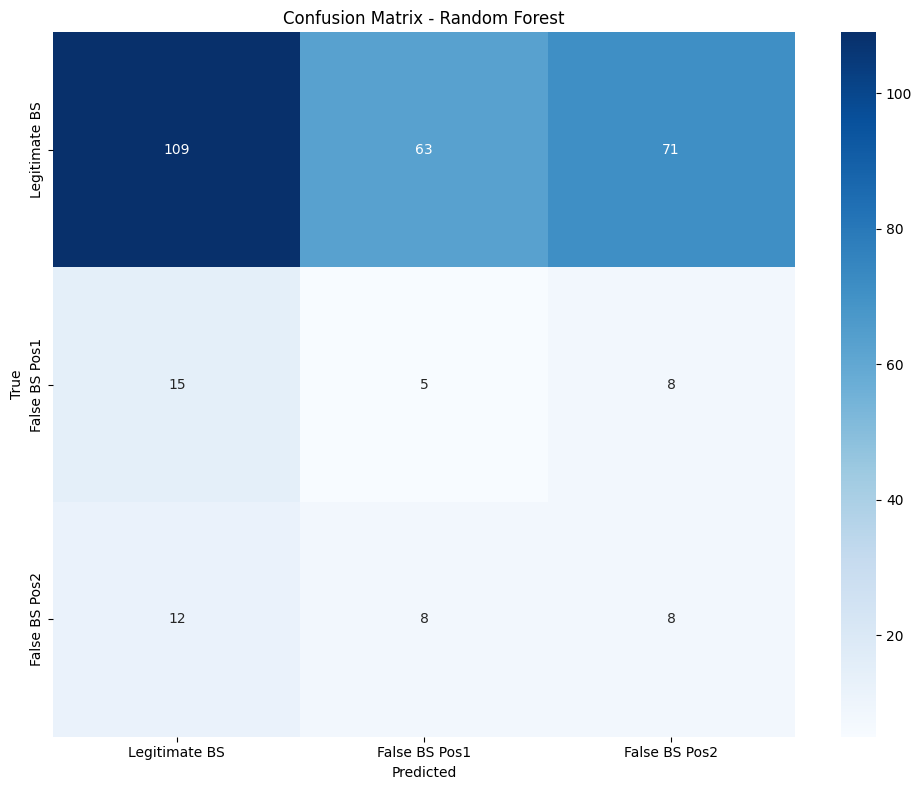

Classification Report - Random Forest:
               precision    recall  f1-score   support

Legitimate BS       0.80      0.45      0.58       243
False BS Pos1       0.07      0.18      0.10        28
False BS Pos2       0.09      0.29      0.14        28

     accuracy                           0.41       299
    macro avg       0.32      0.30      0.27       299
 weighted avg       0.67      0.41      0.49       299



In [ ]:
# Optimize Random Forest hyperparameters
print("Optimizing Random Forest hyperparameters...")
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True],
    'class_weight': ['balanced', 'balanced_subsample', class_weight_dict]
}

# Use a smaller grid for faster execution
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro'  # Changed to f1_macro to focus on all classes equally
)

grid_search.fit(X_train_selected, y_train_balanced)

# Get best parameters
print("Best Random Forest parameters found:")
print(grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Evaluate on validation set
y_val_pred_rf = best_rf_model.predict(X_val_selected)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print(f"Random Forest validation accuracy: {val_accuracy_rf:.4f}")

# Show confusion matrix
plt.figure(figsize=(10, 8))
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

# Show classification report
print("Classification Report - Random Forest:")
print(classification_report(y_val, y_val_pred_rf, target_names=class_names, zero_division=0))

Data Preparation for CNN

In [ ]:
# Reshape data for CNN (add channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], 72, 48, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 72, 48, 1)

# Split into training and validation sets
X_train_cnn_final, X_val_cnn, y_train_cnn_final, y_val_cnn = train_test_split(
    X_train_cnn, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Apply aggressive undersampling to CNN data
print("Applying undersampling to CNN data...")
cnn_under_sampler = RandomUnderSampler(
    sampling_strategy={
        0: min(len(y_train_cnn_final[y_train_cnn_final == 1]) * 2,
              len(y_train_cnn_final[y_train_cnn_final == 0]))
    },
    random_state=42
)

# Reshape for undersampling (needs 2D array)
X_train_cnn_flat = X_train_cnn_final.reshape(X_train_cnn_final.shape[0], -1)
X_train_cnn_flat_balanced, y_train_cnn_balanced = cnn_under_sampler.fit_resample(
    X_train_cnn_flat, y_train_cnn_final
)

# Reshape back to 4D
X_train_cnn_balanced = X_train_cnn_flat_balanced.reshape(-1, 72, 48, 1)

# Normalize the data (scale pixel values between 0 and 1)
X_train_cnn_norm = X_train_cnn_balanced / 255.0
X_val_cnn_norm = X_val_cnn / 255.0
X_test_cnn_norm = X_test_cnn / 255.0

# Convert labels to categorical for CNN
y_train_cnn_cat = tf.keras.utils.to_categorical(y_train_cnn_balanced, num_classes=3)
y_val_cnn_cat = tf.keras.utils.to_categorical(y_val_cnn, num_classes=3)

# Print class distribution for CNN data
print("Class distribution for CNN after undersampling:")
cnn_balanced_counts = pd.Series(y_train_cnn_balanced).value_counts().sort_index()
print(cnn_balanced_counts)

# Setup data augmentation for CNN
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

Applying undersampling to CNN data...
Class distribution for CNN after undersampling:
0    226
1    113
2    113
Name: count, dtype: int64


Building and Training the CNN Model


Building and training CNN model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 72, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 72, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 72, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 72, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 36, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 36, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 18, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,769,72

 Total params: 2,092,771 (7.98 MB)

 Trainable params: 2,091,107 (7.98 MB)

 Non-trainable params: 1,664 (6.50 KB)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.3672 - loss: 4.1798
Epoch 1: val_accuracy improved from -inf to 0.09365, saving model to best_cnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3673 - loss: 4.1717 - val_accuracy: 0.0936 - val_loss: 1.3920 - learning_rate: 3.0000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.2890 - loss: 4.6222
Epoch 2: val_accuracy did not improve from 0.09365
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2900 - loss: 4.5995 - val_accuracy: 0.0936 - val_loss: 1.5869 - learning_rate: 3.0000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.3155 - loss: 4.2058
Epoch 3: val_accuracy did not improve from 0.09365
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3149 - loss: 4.1900 - val_accuracy: 0.0936 - val_loss: 1.6676 - learning_rate: 3.0000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3409 - loss: 3.9453
Epoch 4: val_accuracy did not improve from 0.09365
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3403 - loss: 3.9435 - val_accuracy: 0.0936 - val_loss: 1.8948 - learning_rate: 3.0000e-04
Epoch 5/50
15/15 ━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.1001 - loss: 1.3967
CNN validation accuracy: 0.0936
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step


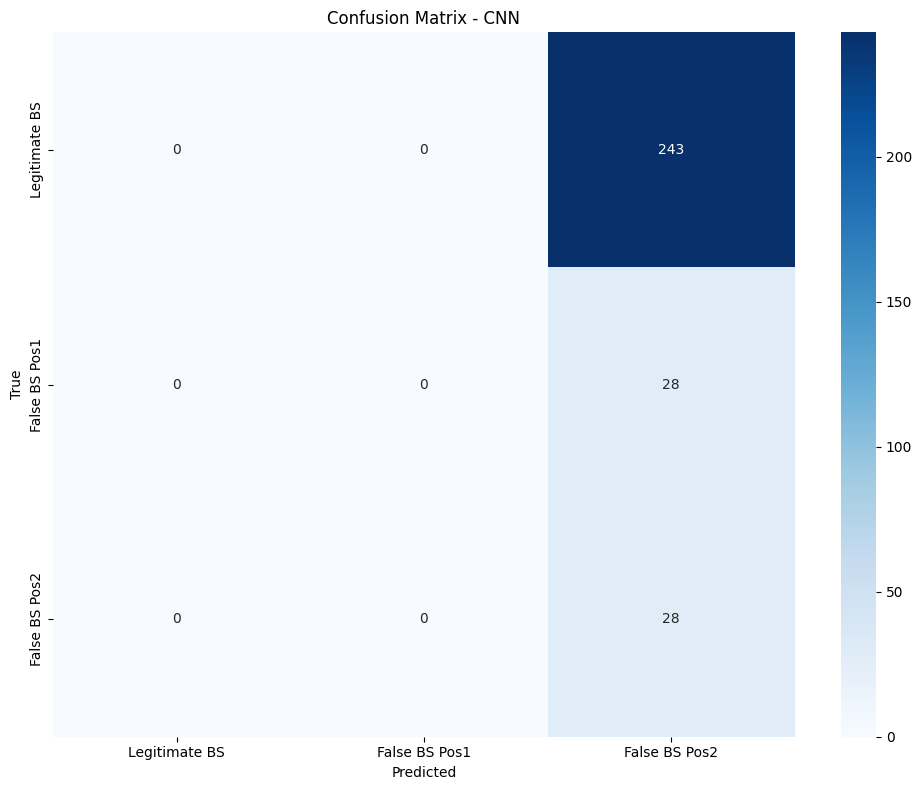

Classification Report - CNN:
               precision    recall  f1-score   support

Legitimate BS       0.00      0.00      0.00       243
False BS Pos1       0.00      0.00      0.00        28
False BS Pos2       0.09      1.00      0.17        28

     accuracy                           0.09       299
    macro avg       0.03      0.33      0.06       299
 weighted avg       0.01      0.09      0.02       299



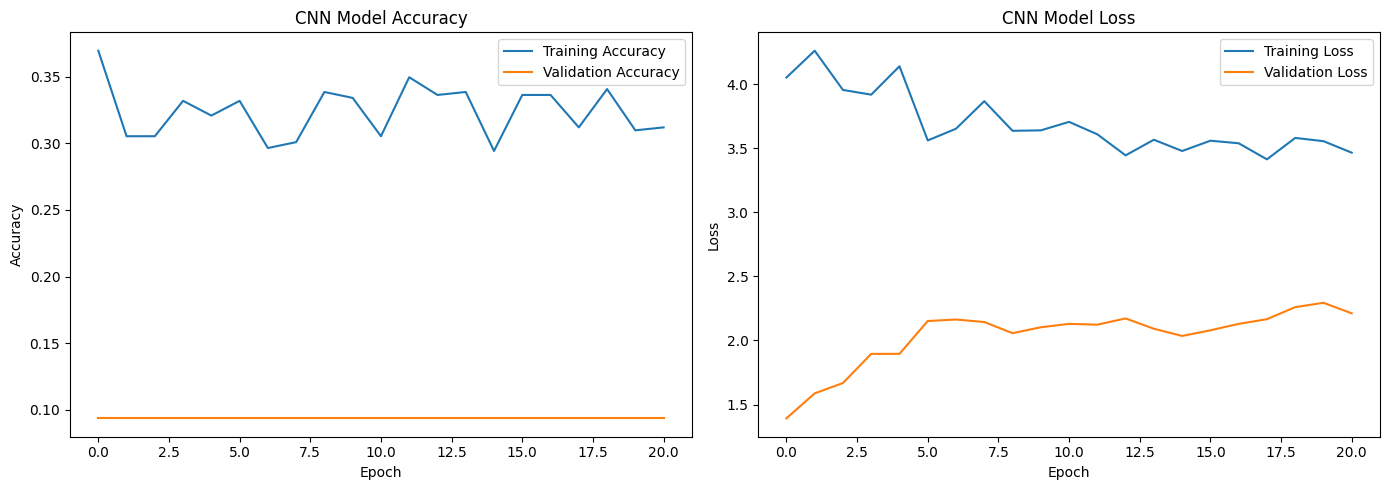

In [ ]:
# Define CNN model with improved architecture for imbalanced data
def create_cnn_model():
    inputs = layers.Input(shape=(72, 48, 1))

    # Data augmentation only during training
    augmented = data_augmentation(inputs)

    # First Convolutional Block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(augmented)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Second Convolutional Block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Third Convolutional Block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Flatten and Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile model with focal loss for better handling of imbalanced data
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train CNN model
print("Building and training CNN model...")
cnn_model = create_cnn_model()
cnn_model.summary()

# Class weights for CNN
cnn_class_weights = {0: 1.0, 1: 3.0, 2: 3.0}  # Simple class weights for CNN

# Setup callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model with class weights
history = cnn_model.fit(
    X_train_cnn_norm, y_train_cnn_cat,
    epochs=50,
    batch_size=32,
    class_weight=cnn_class_weights,
    validation_data=(X_val_cnn_norm, y_val_cnn_cat),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

# Load the best model
best_cnn_model = tf.keras.models.load_model('best_cnn_model.h5')

# Evaluate on validation set
val_loss, val_acc_cnn = best_cnn_model.evaluate(X_val_cnn_norm, y_val_cnn_cat)
print(f"CNN validation accuracy: {val_acc_cnn:.4f}")

# Get predictions
y_val_pred_cnn_probs = best_cnn_model.predict(X_val_cnn_norm)
y_val_pred_cnn = np.argmax(y_val_pred_cnn_probs, axis=1)

# Show confusion matrix
plt.figure(figsize=(10, 8))
cm_cnn = confusion_matrix(y_val_cnn, y_val_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN')
plt.tight_layout()
plt.show()

# Show classification report
print("Classification Report - CNN:")
print(classification_report(y_val_cnn, y_val_pred_cnn, target_names=class_names, zero_division=0))

# Visualize learning curves
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Random Forest and CNN Combination (Ensemble Model)


Creating ensemble model (RF + CNN)...
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step
Ensemble validation accuracy: 0.7124


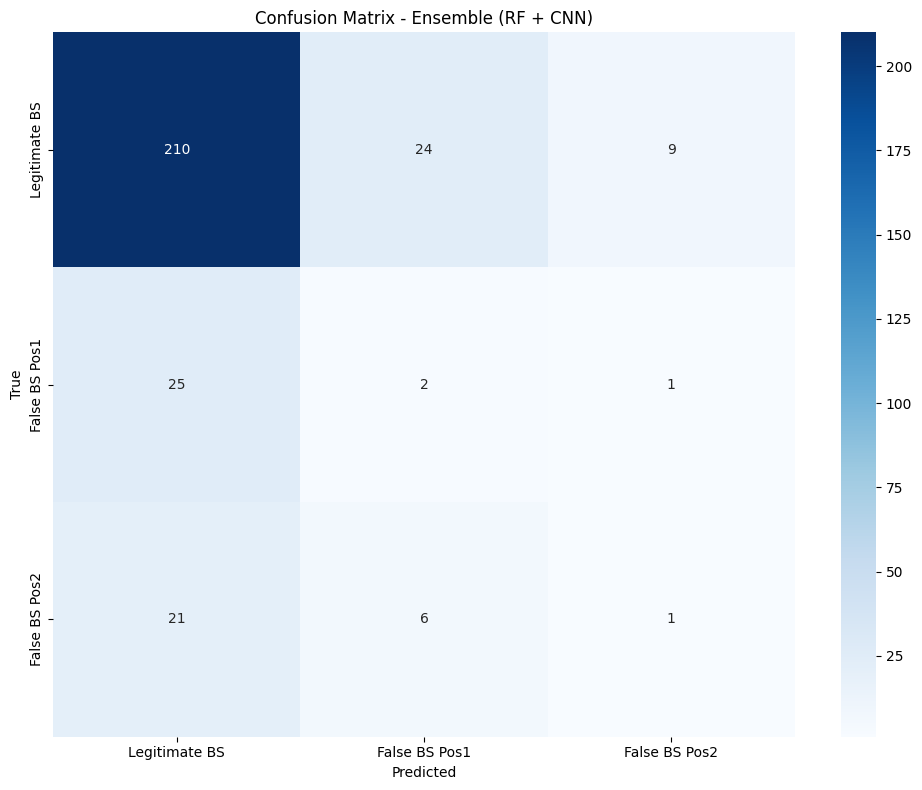

Classification Report - Ensemble (RF + CNN):
               precision    recall  f1-score   support

Legitimate BS       0.82      0.86      0.84       243
False BS Pos1       0.06      0.07      0.07        28
False BS Pos2       0.09      0.04      0.05        28

     accuracy                           0.71       299
    macro avg       0.32      0.32      0.32       299
 weighted avg       0.68      0.71      0.70       299

F1 score for minority classes (1 and 2): 0.0590


In [ ]:
# Create a properly validated ensemble of RF and CNN predictions
print("Creating ensemble model (RF + CNN)...")

# 1. Create a dedicated subset for meta-model training
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    X_train_selected, y_train_balanced, test_size=0.3, random_state=43
)

# 2. Get CNN predictions for meta-training set
# First, find the original indices that correspond to the meta-training set
meta_indices = np.where(np.isin(np.arange(len(X_train_balanced)),
                               np.arange(len(X_train_selected) - len(X_train_meta), len(X_train_selected))))[0]

# Get CNN data for these indices - this is approximate as the indices may not match exactly
X_meta_cnn = X_train_cnn_norm[:len(meta_indices)]
y_meta_cnn = y_train_cnn_balanced[:len(meta_indices)]

# Get CNN predictions for meta-training
meta_cnn_features = best_cnn_model.predict(X_meta_cnn)

# 3. Combine RF features and CNN predictions
X_meta_ensemble = np.column_stack((X_train_meta, meta_cnn_features))

# 4. Train ensemble model
meta_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

meta_model.fit(X_meta_ensemble, y_train_meta)

# 5. Get CNN predictions for validation set
X_val_cnn_features = best_cnn_model.predict(X_val_cnn_norm)

# 6. Create ensemble validation features
X_val_ensemble = np.column_stack((X_val_selected, X_val_cnn_features))

# 7. Make predictions with ensemble model
y_val_ensemble_pred = meta_model.predict(X_val_ensemble)
ensemble_accuracy = accuracy_score(y_val, y_val_ensemble_pred)
print(f"Ensemble validation accuracy: {ensemble_accuracy:.4f}")

# Show confusion matrix for ensemble
plt.figure(figsize=(10, 8))
cm_ensemble = confusion_matrix(y_val, y_val_ensemble_pred)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ensemble (RF + CNN)')
plt.tight_layout()
plt.show()

# Show classification report for ensemble
print("Classification Report - Ensemble (RF + CNN):")
print(classification_report(y_val, y_val_ensemble_pred, target_names=class_names, zero_division=0))

# Calculate F1 score specifically for minority classes
from sklearn.metrics import f1_score
f1_minority = f1_score(y_val, y_val_ensemble_pred, labels=[1, 2], average='macro', zero_division=0)
print(f"F1 score for minority classes (1 and 2): {f1_minority:.4f}")

Model Comparison and Final Predictions


--- Model Comparison ---
Random Forest Accuracy: 0.4080
CNN Accuracy: 0.0936
Ensemble Accuracy: 0.7124
Random Forest F1 (minority): 0.1176
CNN F1 (minority): 0.0856
Ensemble F1 (minority): 0.0590

Best model for minority detection: Random Forest with F1 score: 0.1176


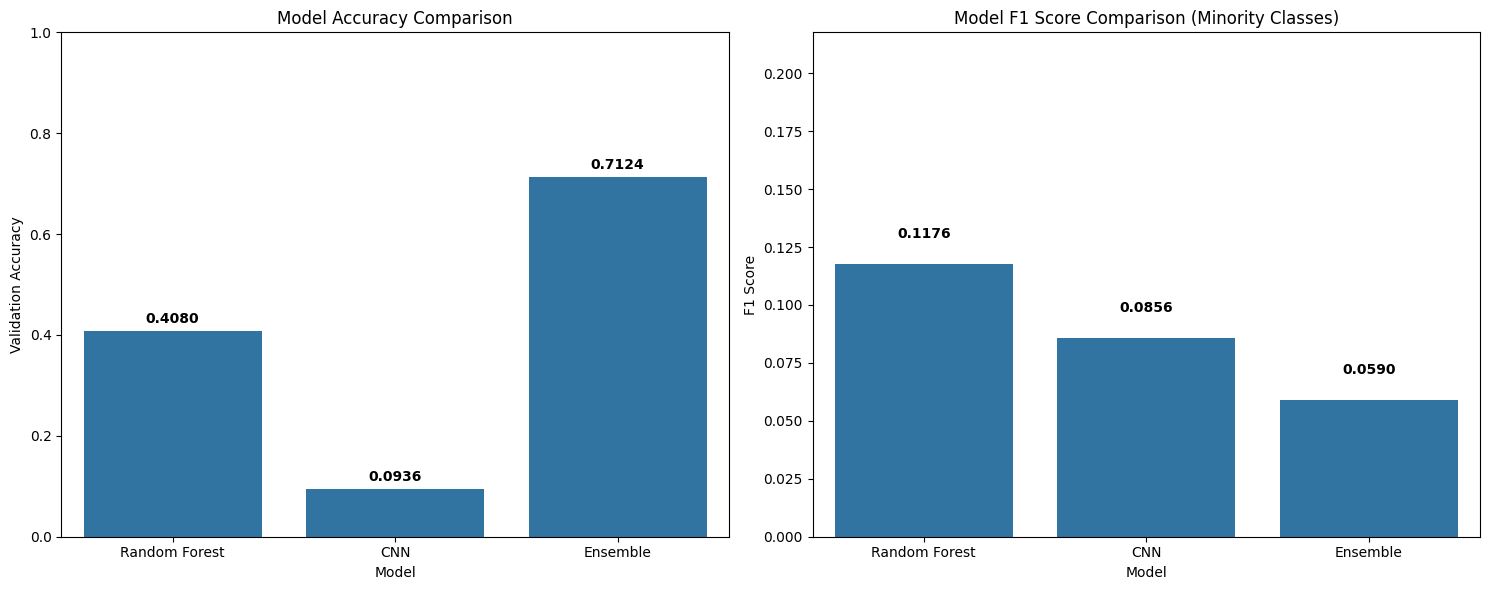

Generating test predictions using Random Forest...
Predictions saved to 'submission_random_forest_no_smote.csv'


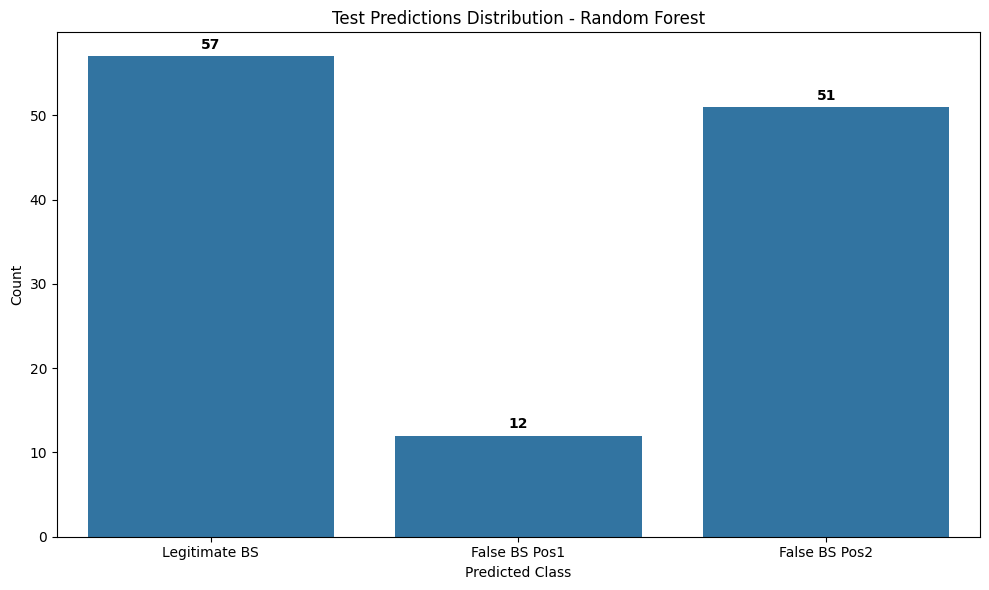

In [ ]:
# Compare all models
print("\n--- Model Comparison ---")
print(f"Random Forest Accuracy: {val_accuracy_rf:.4f}")
print(f"CNN Accuracy: {val_acc_cnn:.4f}")
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Calculate F1 scores for minority classes for each model
rf_f1_minority = f1_score(y_val, y_val_pred_rf, labels=[1, 2], average='macro', zero_division=0)
cnn_f1_minority = f1_score(y_val_cnn, y_val_pred_cnn, labels=[1, 2], average='macro', zero_division=0)

print(f"Random Forest F1 (minority): {rf_f1_minority:.4f}")
print(f"CNN F1 (minority): {cnn_f1_minority:.4f}")
print(f"Ensemble F1 (minority): {f1_minority:.4f}")

# Determine the best model based on F1 score for minority classes
f1_scores = [rf_f1_minority, cnn_f1_minority, f1_minority]
models = ["Random Forest", "CNN", "Ensemble"]
best_index = np.argmax(f1_scores)
best_model_name = models[best_index]
best_f1 = f1_scores[best_index]

print(f"\nBest model for minority detection: {best_model_name} with F1 score: {best_f1:.4f}")

# Plot accuracy and F1 comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
sns.barplot(x=models, y=[val_accuracy_rf, val_acc_cnn, ensemble_accuracy], ax=ax1)
ax1.set_title("Model Accuracy Comparison")
ax1.set_xlabel("Model")
ax1.set_ylabel("Validation Accuracy")
for i, acc in enumerate([val_accuracy_rf, val_acc_cnn, ensemble_accuracy]):
    ax1.text(i, acc + 0.01, f"{acc:.4f}", ha='center', va='bottom', fontweight='bold')
ax1.set_ylim(0, 1)

# F1 comparison
sns.barplot(x=models, y=f1_scores, ax=ax2)
ax2.set_title("Model F1 Score Comparison (Minority Classes)")
ax2.set_xlabel("Model")
ax2.set_ylabel("F1 Score")
for i, f1 in enumerate(f1_scores):
    ax2.text(i, f1 + 0.01, f"{f1:.4f}", ha='center', va='bottom', fontweight='bold')
ax2.set_ylim(0, max(f1_scores) + 0.1)

plt.tight_layout()
plt.show()

# Generate predictions for test set based on the best model for minority detection
print(f"Generating test predictions using {best_model_name}...")

if best_model_name == "Random Forest":
    test_predictions = best_rf_model.predict(X_test_selected)
elif best_model_name == "CNN":
    test_predictions = np.argmax(best_cnn_model.predict(X_test_cnn_norm), axis=1)
else:  # Ensemble
    # Prepare test data for ensemble
    X_test_cnn_features = best_cnn_model.predict(X_test_cnn_norm)
    X_test_ensemble = np.column_stack((X_test_selected, X_test_cnn_features))
    test_predictions = meta_model.predict(X_test_ensemble)

# Save predictions to CSV for submission
submission = pd.read_csv(test_format_path)
submission.iloc[:, 1] = test_predictions
submission_filename = f'submission_{best_model_name.lower().replace(" ", "_")}_no_smote.csv'
submission.to_csv(submission_filename, index=False)
print(f"Predictions saved to '{submission_filename}'")

# Visualize test predictions distribution
plt.figure(figsize=(10, 6))
test_pred_counts = pd.Series(test_predictions).value_counts().sort_index()
sns.barplot(x=[class_names[i] if i in test_pred_counts.index else class_names[i] for i in range(3)],
            y=[test_pred_counts.get(i, 0) for i in range(3)])
plt.title(f"Test Predictions Distribution - {best_model_name}")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
for i, count in enumerate([test_pred_counts.get(i, 0) for i in range(3)]):
    plt.text(i, count + 0.5, f"{count}", ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

Feature Importance Analysis and Misclassified Samples

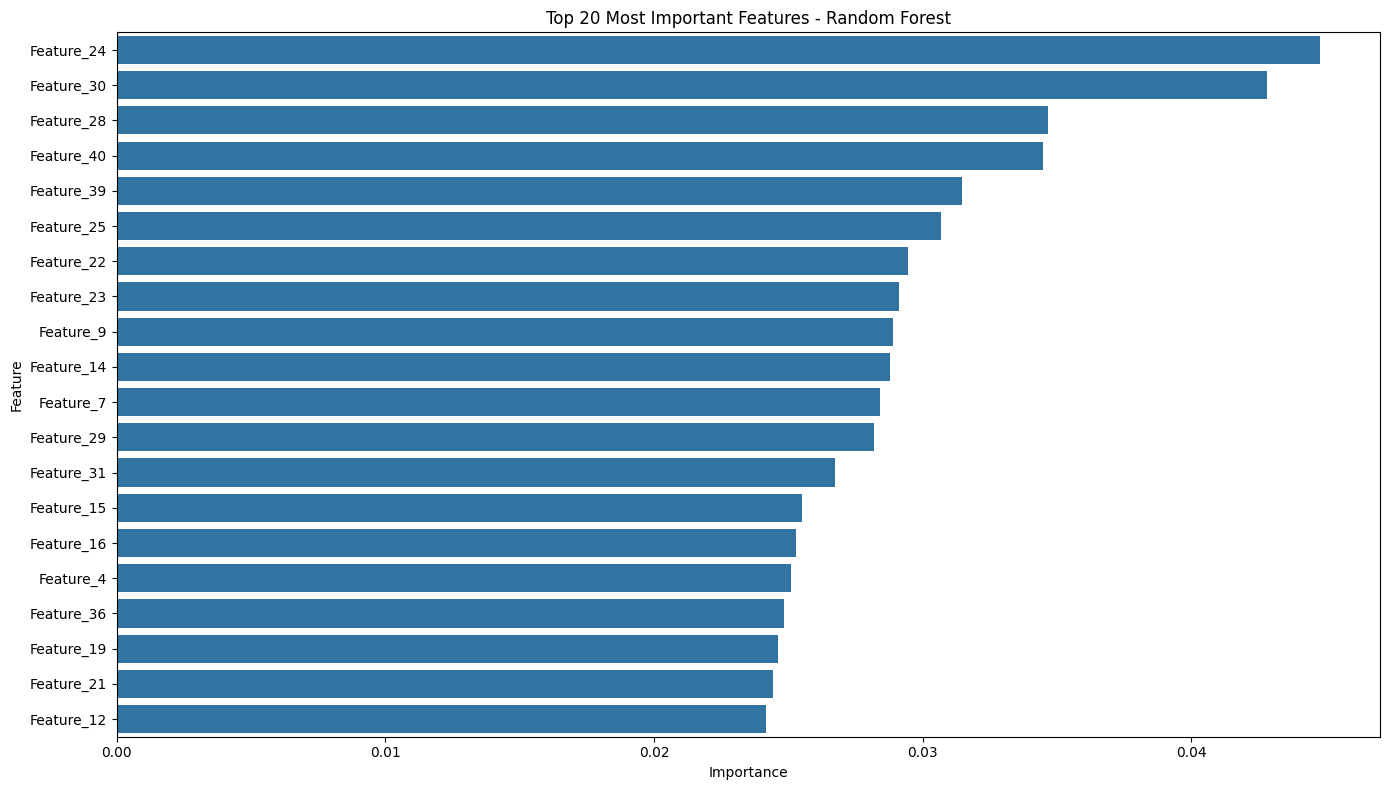


--- Analysis of Misclassified Samples ---
Random Forest:


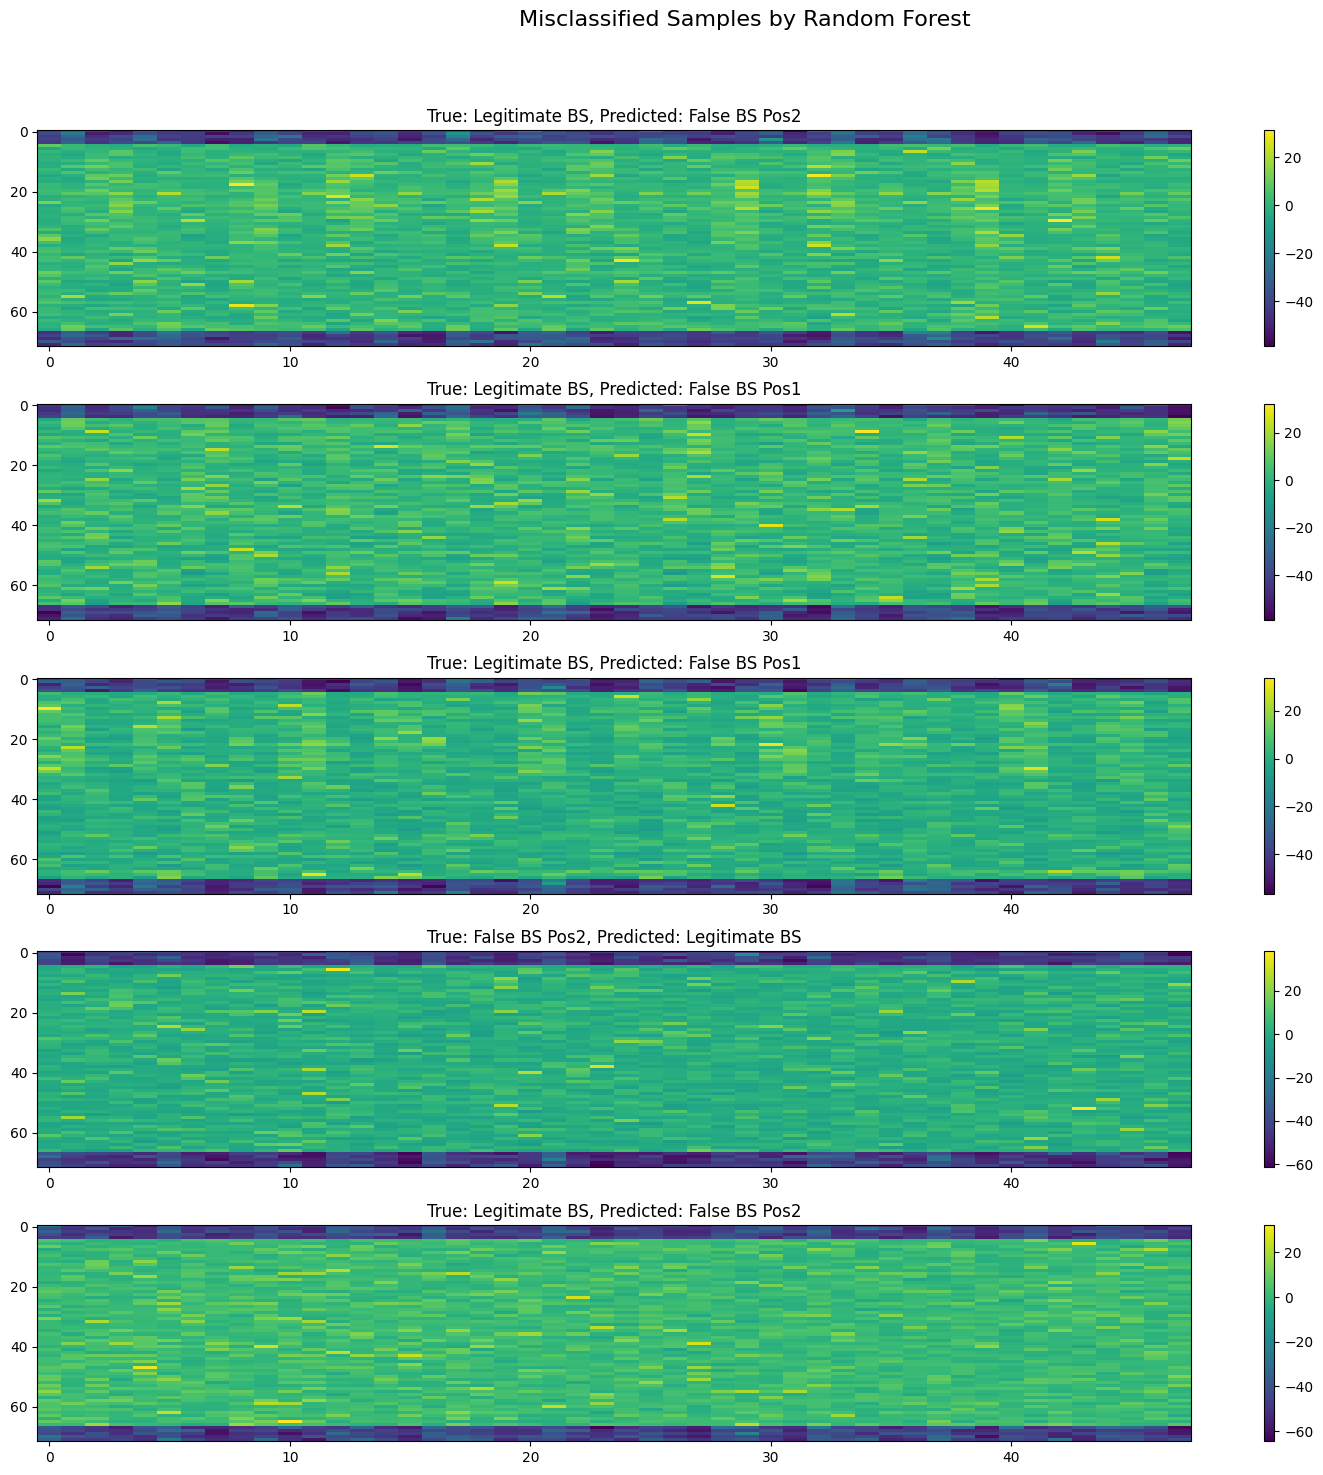

CNN:


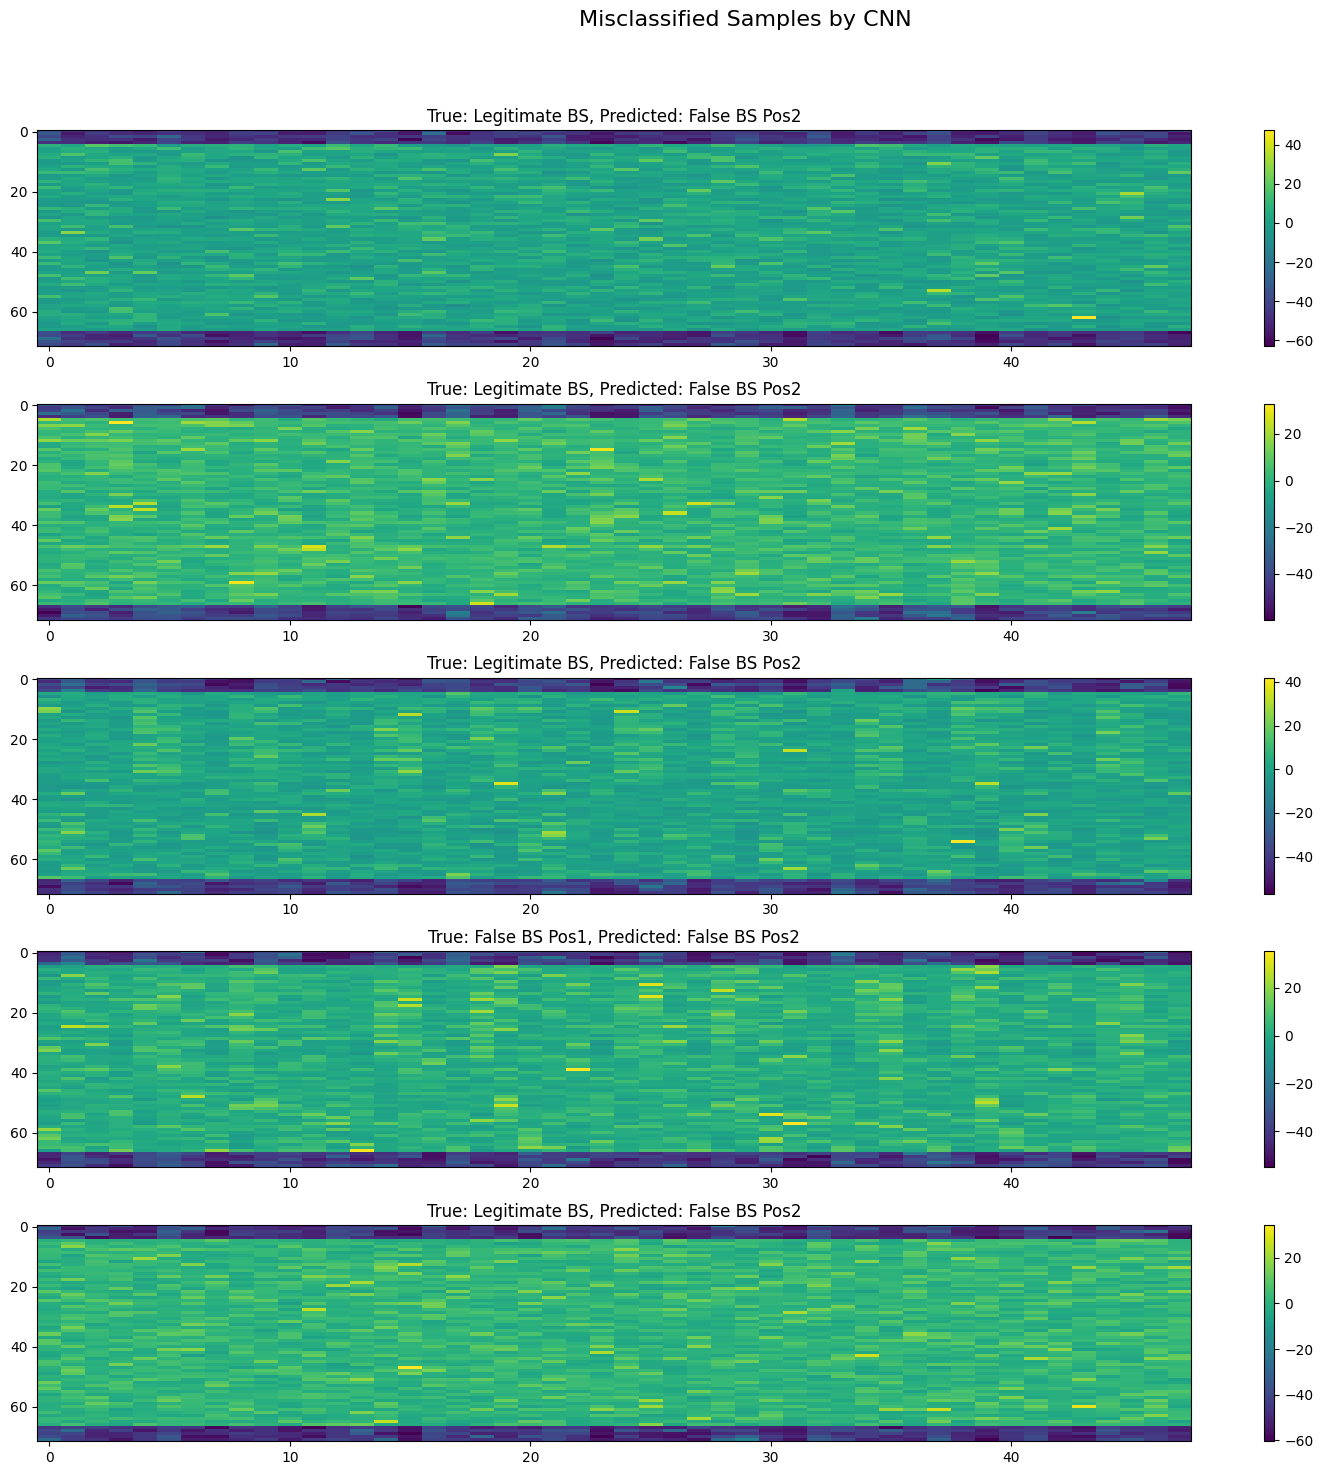

Ensemble:


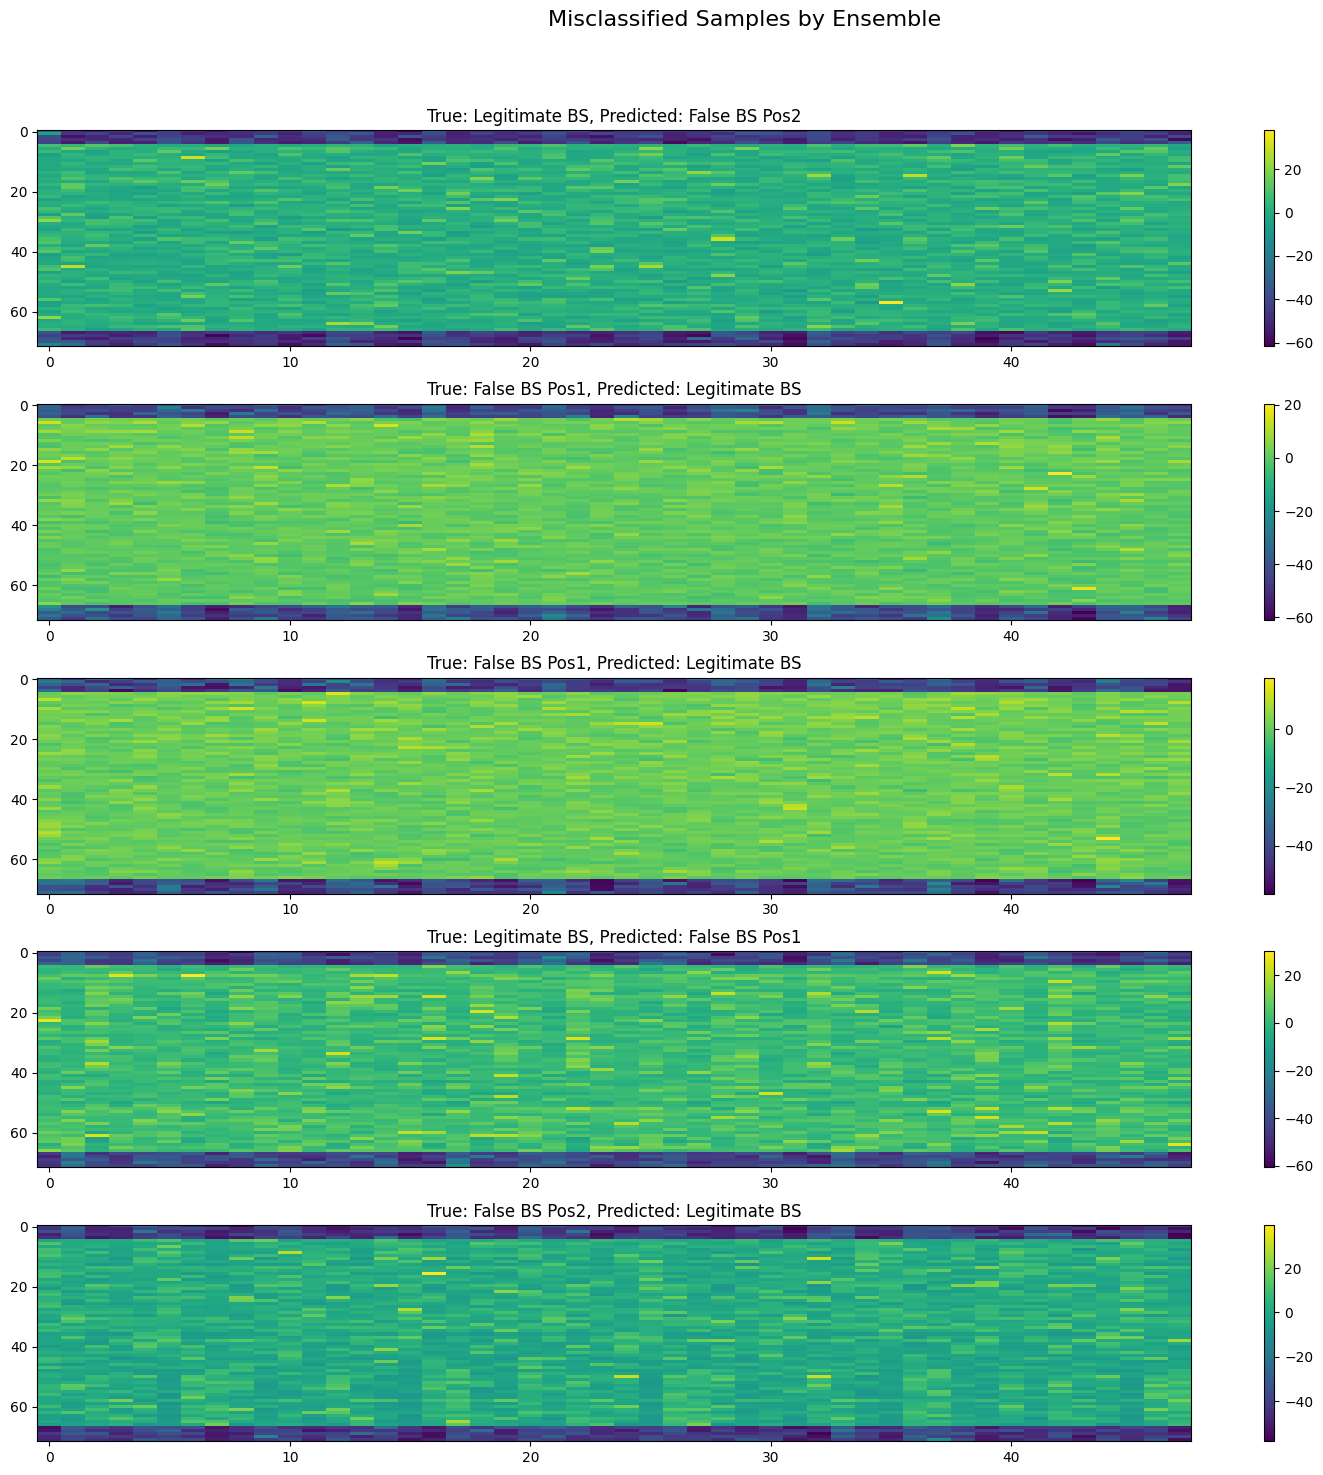

In [ ]:
# Feature importance analysis for Random Forest
plt.figure(figsize=(14, 8))
if hasattr(best_rf_model, 'feature_importances_'):
    # Get feature importance
    importances = best_rf_model.feature_importances_

    # Get feature names using selected indices
    feature_names = [f'Feature_{idx}' for idx in selected_features_indices]

    # Create DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Visualize top 20 features
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title('Top 20 Most Important Features - Random Forest')
    plt.tight_layout()
    plt.show()

# Function to visualize misclassified samples
def plot_misclassified_samples(X_original, y_true, y_pred, class_names, model_name, num_samples=5):
    # Identify misclassified samples
    misclassified_indices = np.where(y_true != y_pred)[0]

    if len(misclassified_indices) == 0:
        print(f"No misclassified samples by {model_name}.")
        return

    num_samples = min(num_samples, len(misclassified_indices))
    selected_indices = np.random.choice(misclassified_indices, num_samples, replace=False)

    # Create visualization
    plt.figure(figsize=(15, 3*num_samples))
    plt.suptitle(f"Misclassified Samples by {model_name}", fontsize=16)

    for i, idx in enumerate(selected_indices):
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(X_original[idx], aspect='auto', cmap='viridis')
        plt.title(f"True: {class_names[y_true[idx]]}, Predicted: {class_names[y_pred[idx]]}")
        plt.colorbar()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Get original validation samples
val_indices = np.arange(len(X_train))[np.isin(np.arange(len(X_train)),
                                             np.where(~np.isin(np.arange(len(X_train)),
                                                               np.arange(len(X_train_final))))[0])]
X_val_original = X_train[val_indices]

# Visualize misclassified samples for each model
print("\n--- Analysis of Misclassified Samples ---")
print("Random Forest:")
plot_misclassified_samples(X_val_original, y_val, y_val_pred_rf, class_names, "Random Forest")

print("CNN:")
plot_misclassified_samples(X_val_original, y_val_cnn, y_val_pred_cnn, class_names, "CNN")

print("Ensemble:")
plot_misclassified_samples(X_val_original, y_val, y_val_ensemble_pred, class_names, "Ensemble")

Detailed Visualization of Predictions by Class


--- Detailed Analysis for Random Forest ---
Class 0 (Legitimate BS) - Accuracy: 0.4486 (109/243)
Class 1 (False BS Pos1) - Accuracy: 0.1786 (5/28)
Class 2 (False BS Pos2) - Accuracy: 0.2857 (8/28)


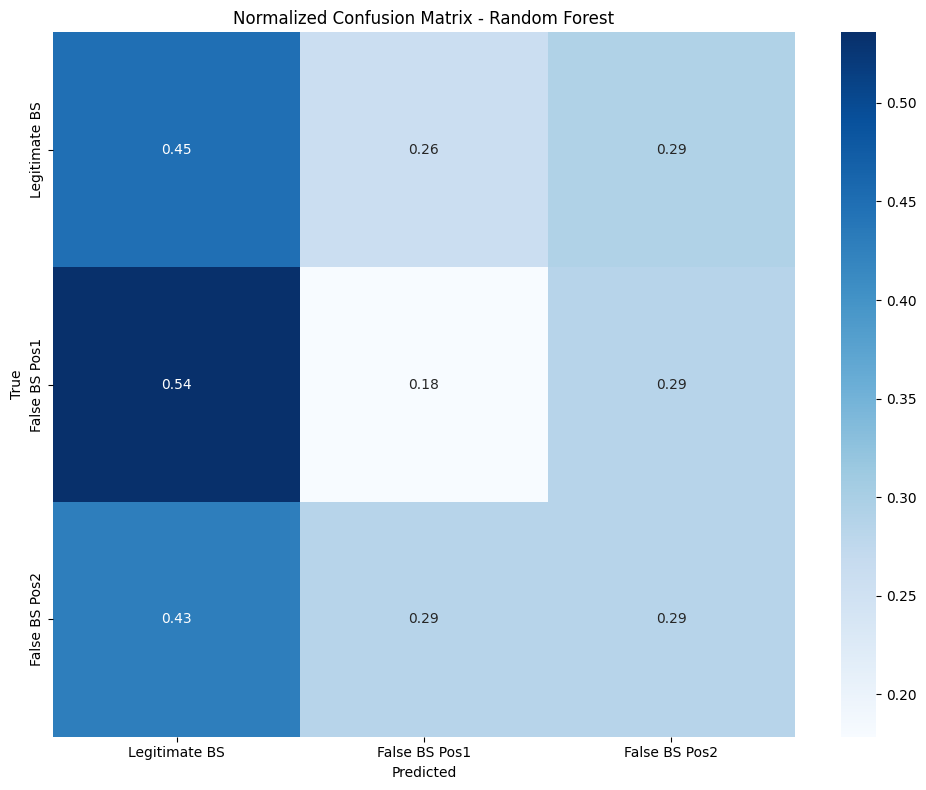


--- Detailed Analysis for CNN ---
Class 0 (Legitimate BS) - Accuracy: 0.0000 (0/243)
Class 1 (False BS Pos1) - Accuracy: 0.0000 (0/28)
Class 2 (False BS Pos2) - Accuracy: 1.0000 (28/28)


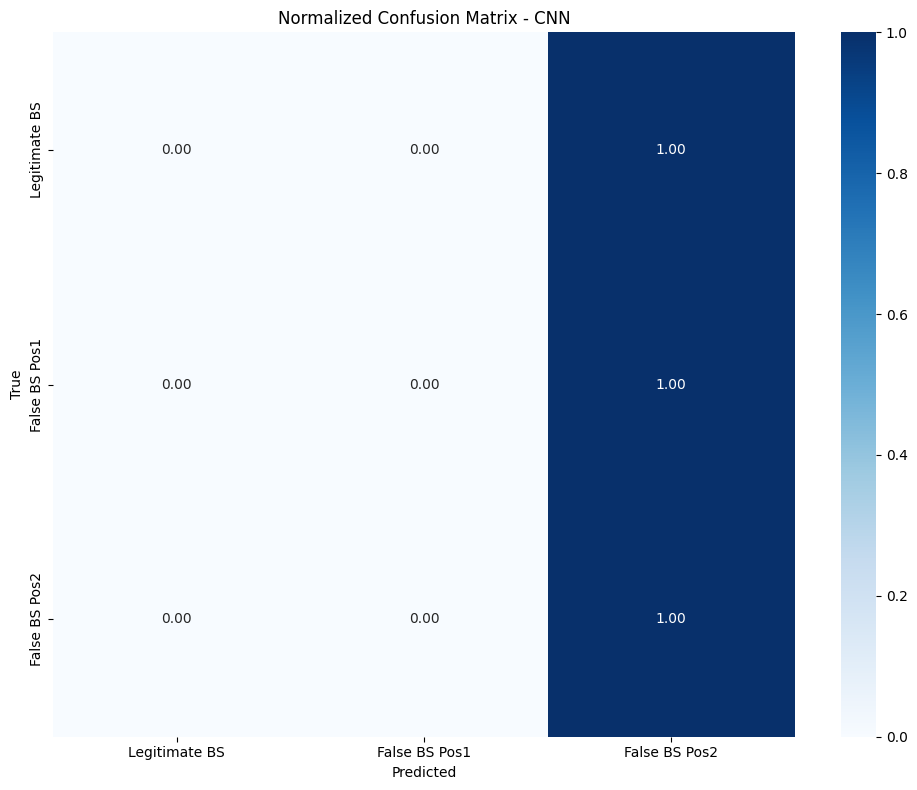


--- Detailed Analysis for Ensemble ---
Class 0 (Legitimate BS) - Accuracy: 0.8642 (210/243)
Class 1 (False BS Pos1) - Accuracy: 0.0714 (2/28)
Class 2 (False BS Pos2) - Accuracy: 0.0357 (1/28)


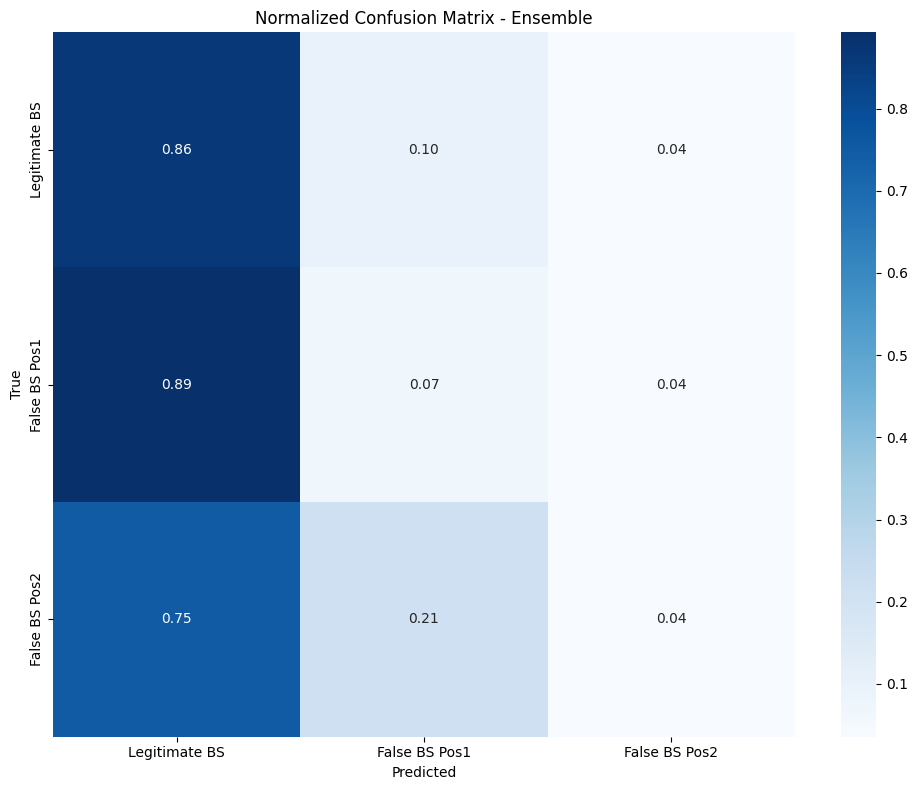

<Figure size 1200x600 with 0 Axes>

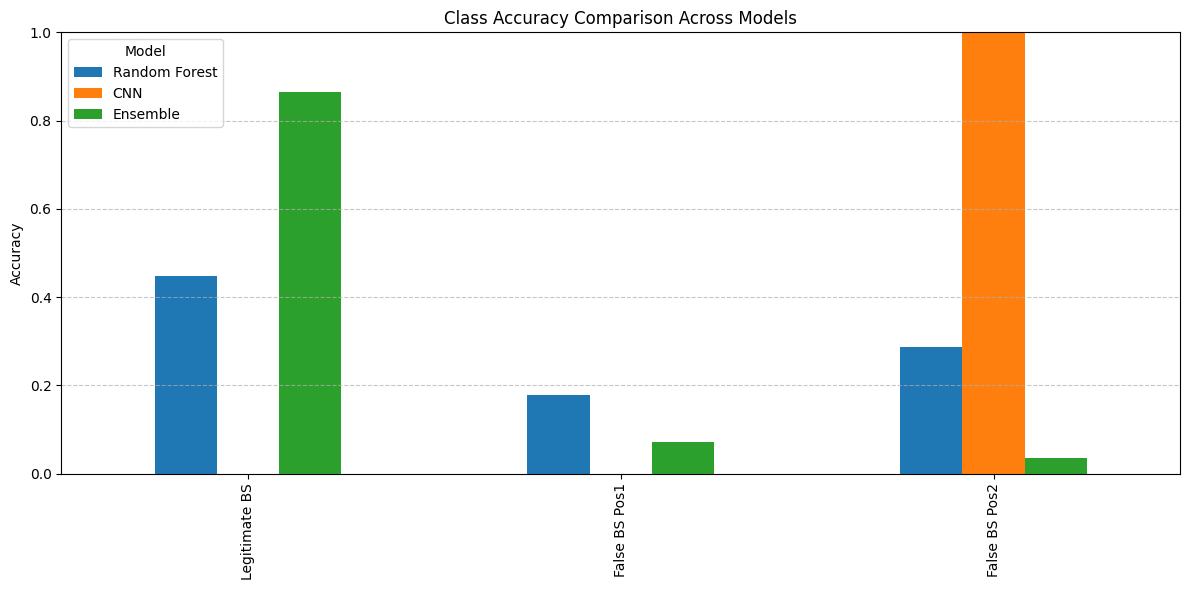

In [ ]:
# Detailed analysis of predictions by class
def analyze_predictions_by_class(y_true, y_pred, class_names, model_name):
    print(f"\n--- Detailed Analysis for {model_name} ---")

    # Calculate accuracy per class
    class_accuracy = {}
    for cls in range(len(class_names)):
        class_mask = (y_true == cls)
        if np.sum(class_mask) > 0:  # Avoid division by zero
            correct = np.sum((y_pred == cls) & class_mask)
            total = np.sum(class_mask)
            class_accuracy[cls] = correct / total
            print(f"Class {cls} ({class_names[cls]}) - Accuracy: {class_accuracy[cls]:.4f} ({correct}/{total})")

    # Confusion analysis
    cm = confusion_matrix(y_true, y_pred)

    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

    return class_accuracy

# Analyze each model's predictions
rf_class_acc = analyze_predictions_by_class(y_val, y_val_pred_rf, class_names, "Random Forest")
cnn_class_acc = analyze_predictions_by_class(y_val_cnn, y_val_pred_cnn, class_names, "CNN")
ensemble_class_acc = analyze_predictions_by_class(y_val, y_val_ensemble_pred, class_names, "Ensemble")

# Compare class accuracies across models
class_acc_df = pd.DataFrame({
    'Random Forest': [rf_class_acc.get(i, 0) for i in range(len(class_names))],
    'CNN': [cnn_class_acc.get(i, 0) for i in range(len(class_names))],
    'Ensemble': [ensemble_class_acc.get(i, 0) for i in range(len(class_names))]
}, index=class_names)

# Plot class accuracies comparison
plt.figure(figsize=(12, 6))
class_acc_df.plot(kind='bar', figsize=(12, 6))
plt.title('Class Accuracy Comparison Across Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

Final Summary and Conclusions

In [ ]:
total_execution_time = time.time() - start_time

print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)
print(f"Total execution time: {total_execution_time/60:.2f} minutes")


print("\nClass Distribution in Training Data:")
for i, count in enumerate(train_class_counts.values):
    print(f"- Class {i} ({class_names[i]}): {count} samples ({count/len(y_train)*100:.1f}%)")

print("\nFeature Analysis:")
print(f"- Total features extracted: {X_train_features.shape[1]}")
print(f"- Features selected: {X_train_selected.shape[1]}")
top_5_features = feature_importance_df.head(5)['Feature'].tolist()
print(f"- Top 5 most important features: {', '.join(top_5_features)}")

print("\nSubmission File:")
print(f"- Predictions saved to: {submission_filename}")
print(f"- Test set prediction distribution: Class 0: {np.sum(test_predictions==0)}, Class 1: {np.sum(test_predictions==1)}, Class 2: {np.sum(test_predictions==2)}")


NameError: name 'time' is not defined